<a href="https://colab.research.google.com/github/gyana-ranjan-dash/World_proverty_analysis/blob/main/World_poverty_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

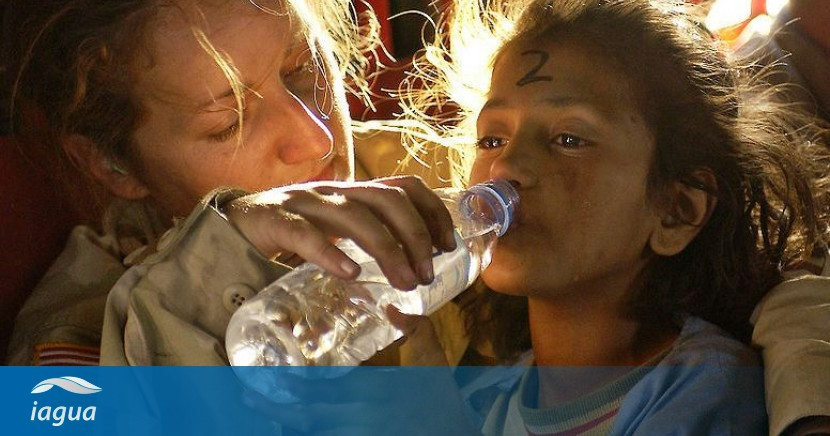

In [119]:
import warnings
warnings.filterwarnings('ignore')


#Important libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## **1. Reading and understanding Dataset**

In [120]:
# importing data from CSV file

country_df = pd.read_csv("https://raw.githubusercontent.com/gyana-ranjan-dash/World_proverty_analysis/main/Country-data.csv")

In [121]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [122]:
country_df.shape

(167, 10)

In [123]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [124]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [125]:
country_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [126]:
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100

In [127]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [128]:
df = country_df[["country","child_mort","income","gdpp"]]
df.head()


,country,child_mort,income,gdpp
0,Afghanistan,90.2,1610,553
1,Albania,16.6,9930,4090
2,Algeria,27.3,12900,4460
3,Angola,119.0,5900,3530
4,Antigua and Barbuda,10.3,19100,12200


In [129]:
df.columns

Index(['country', 'child_mort', 'income', 'gdpp'], dtype='object')

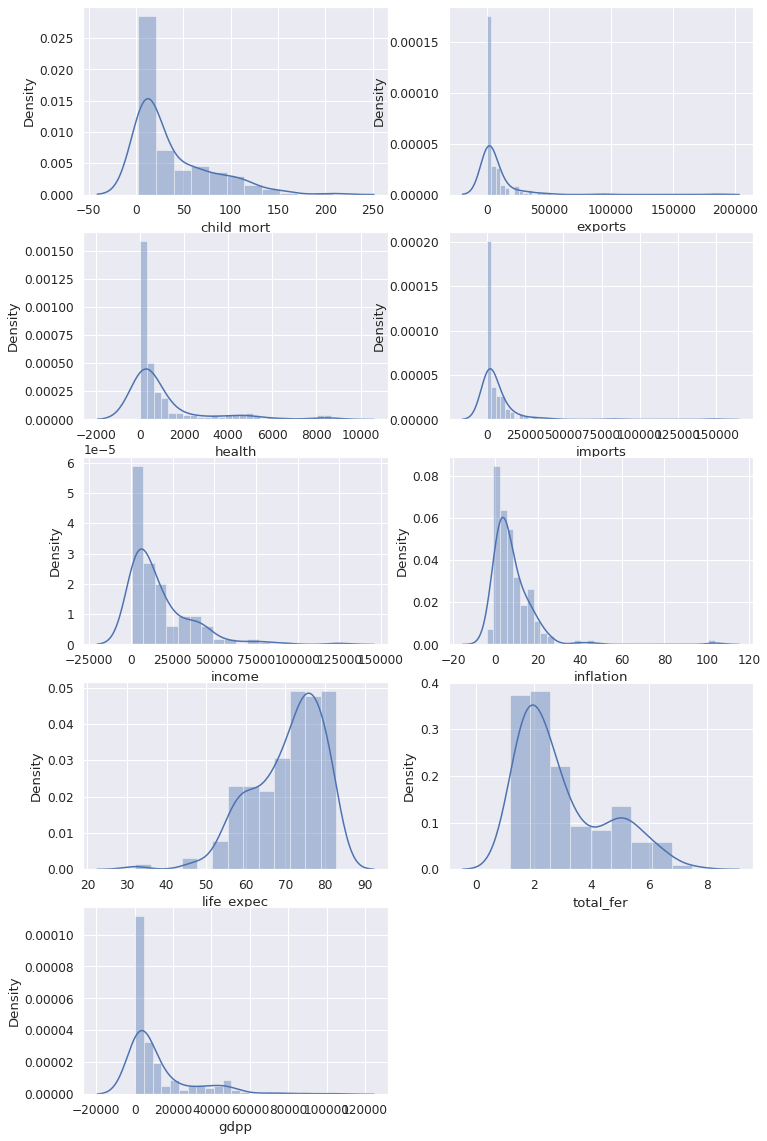

In [130]:
plt.figure(figsize=(12,20))
sns.set(font_scale = 1.1)
cols = country_df.columns[1:]
for i in enumerate(cols):
    plt.subplot(5,2,i[0]+1)
    sns.distplot(country_df[i[1]])
plt.show()

<Figure size 720x360 with 0 Axes>

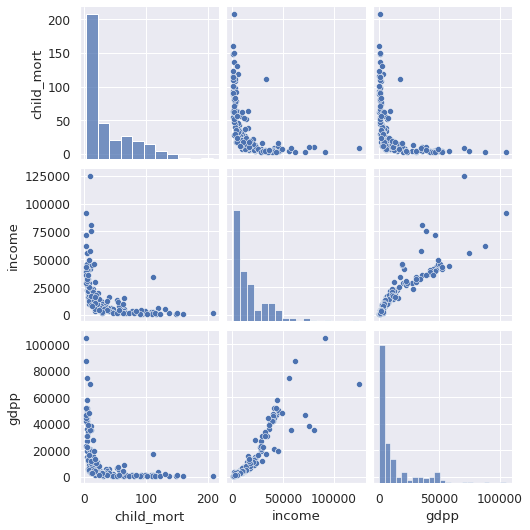

In [131]:
plt.figure(figsize=(10,5))
sns.pairplot(df)
plt.show()

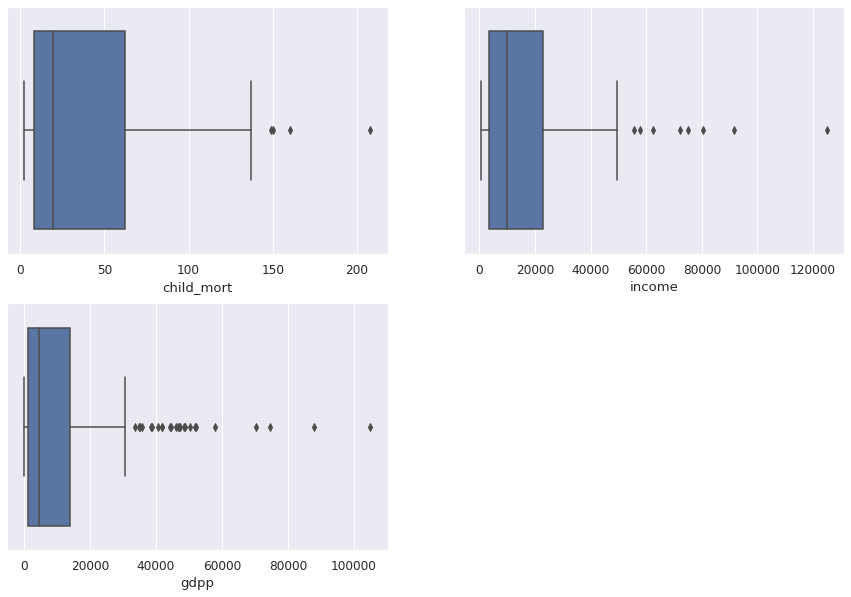

In [132]:
plt.figure(figsize = (15,10))
features = df.columns[1:]
for i in enumerate(features):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(df[i[1]])

In [133]:
# caping the outliers
q1 = df['gdpp'].quantile(0.95)
q2 = df['income'].quantile(0.95)
df['gdpp'][df['gdpp']>=q1] = q1
df['income'][df['income']>=q2] = q2

In [134]:
df1 = df.drop ('country', axis = 1)

In [135]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1 = scaler.fit_transform(df1)

In [136]:
df1 = pd.DataFrame(df1)
df1.columns = df.columns[1:]
df1.head()

,child_mort,income,gdpp
0,1.291532,-0.958349,-0.757362
1,-0.538949,-0.394006,-0.523321
2,-0.272833,-0.192552,-0.498838
3,2.007808,-0.667360,-0.560376
4,-0.695634,0.227992,0.013312


In [137]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [138]:
hopkins(df.drop('country',axis = 1))

0.9426973162296062

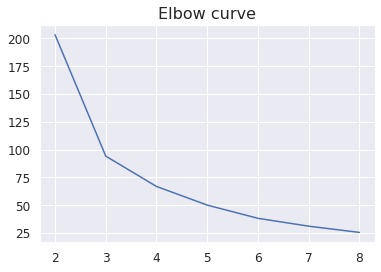

In [139]:
ssd = []
labels= [2, 3, 4, 5, 6, 7, 8]
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df1)
    
    ssd.append(kmeans.inertia_)
plt.plot(ssd)
plt.title('Elbow curve',fontsize = 16)
plt.xticks([0,1,2,3,4,5,6],labels)
plt.show()

In [140]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df1)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df1, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5871919150714086
For n_clusters=3, the silhouette score is 0.554866692350976
For n_clusters=4, the silhouette score is 0.48109595331792393
For n_clusters=5, the silhouette score is 0.47757984716780016
For n_clusters=6, the silhouette score is 0.4699766850573599
For n_clusters=7, the silhouette score is 0.47592594122241
For n_clusters=8, the silhouette score is 0.4812482424169788


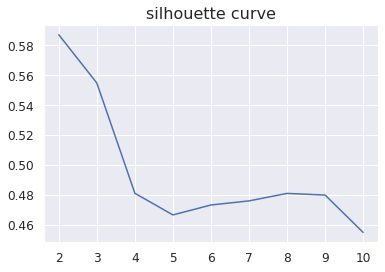

In [141]:
from sklearn.metrics import silhouette_score
ss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmeans.labels_)])

plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])
plt.title('silhouette curve',fontsize = 16)
plt.show()

In [142]:
# K=3
kmean = KMeans(n_clusters = 3, random_state = 101)
kmean.fit(df1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

In [143]:
cluster_id = pd.DataFrame(kmean.labels_, columns = ['cluster_id'])
df.kmean = df.copy()
df.kmean = pd.concat([df.kmean, cluster_id ], axis =1)

In [144]:
df.kmean.head()

,country,child_mort,income,gdpp,cluster_id
0,Afghanistan,90.2,1610.0,553,0
1,Albania,16.6,9930.0,4090,2
2,Algeria,27.3,12900.0,4460,2
3,Angola,119.0,5900.0,3530,0
4,Antigua and Barbuda,10.3,19100.0,12200,2


In [145]:
df['cluster_id']=kmean.labels_

In [146]:
df.head()

,country,child_mort,income,gdpp,cluster_id
0,Afghanistan,90.2,1610.0,553,0
1,Albania,16.6,9930.0,4090,2
2,Algeria,27.3,12900.0,4460,2
3,Angola,119.0,5900.0,3530,0
4,Antigua and Barbuda,10.3,19100.0,12200,2


In [147]:
country_df['k_means_cluster'] = kmean.labels_
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_means_cluster
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,2


In [148]:
df.cluster_id.value_counts()

2    83
0    46
1    38
Name: cluster_id, dtype: int64

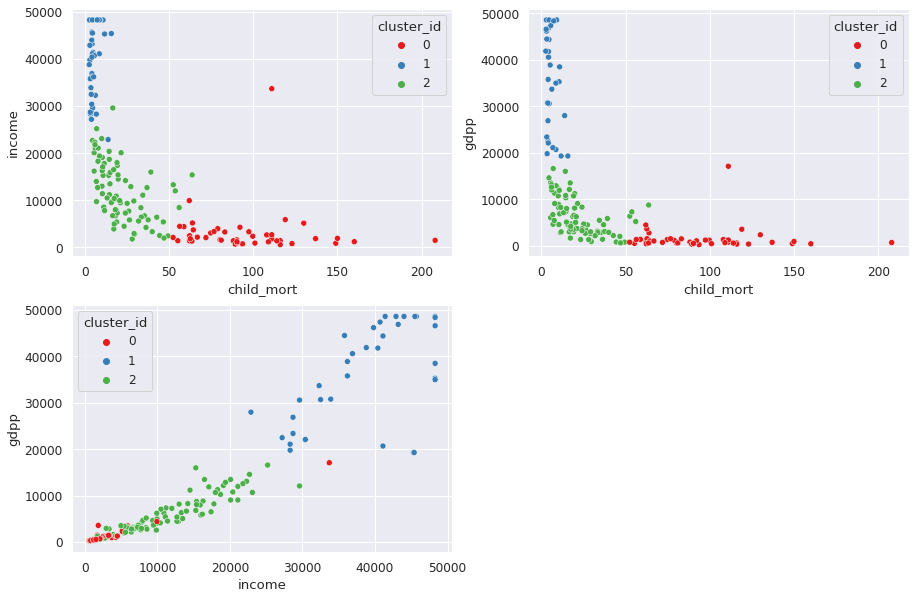

In [149]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'cluster_id', data = df, palette = 'Set1')
plt.subplot(2,2,2)
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'cluster_id', data = df, palette = 'Set1')
plt.subplot(2,2,3)
sns.scatterplot(x = 'income', y = 'gdpp', hue = 'cluster_id', data = df, palette = 'Set1')

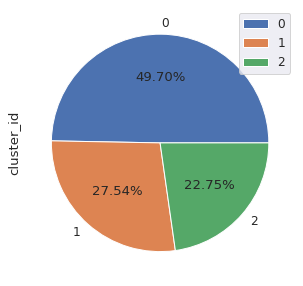

In [150]:
plt.figure(figsize= (5,5))
df['cluster_id'].value_counts().plot(kind= 'pie', legend = True, autopct='%1.2f%%',labels=[0,1,2], shadow=False)
plt.show()

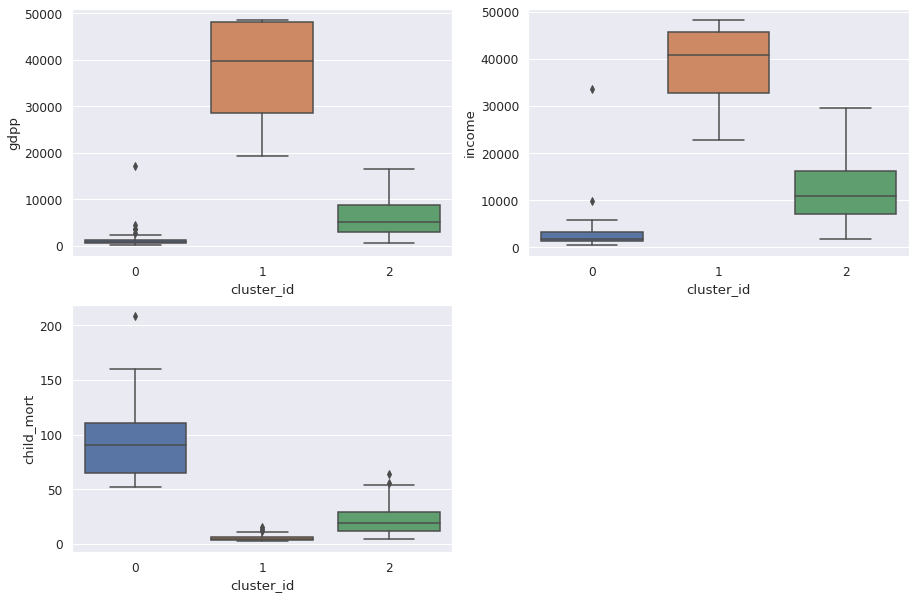

In [151]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.boxplot(x='cluster_id', y='gdpp', data=df)
plt.subplot(2,2,2)
sns.boxplot(x='cluster_id', y='income', data=df)
plt.subplot(2,2,3)
sns.boxplot(x='cluster_id', y='child_mort', data=df)
plt.show()

In [152]:
df.kmean.drop('country',axis = 1).groupby('cluster_id').mean()

,child_mort,income,gdpp
cluster_id,,,
0,94.434783,3122.021739,1430.391304
1,5.636842,39416.052632,37331.315789
2,22.083133,11890.963855,6258.024096


In [153]:
df.kmean[df['cluster_id'] ==0]['country']

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
69                        India
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106                  Mozambique
107                     Myanmar
112     

In [154]:
df.kmean[df['cluster_id'] ==0].sort_values(by = ['child_mort','income','gdpp'], ascending = [False,True,True]).head(5)

,country,child_mort,income,gdpp,cluster_id
66,Haiti,208.0,1500.0,662,0
132,Sierra Leone,160.0,1220.0,399,0
32,Chad,150.0,1930.0,897,0
31,Central African Republic,149.0,888.0,446,0
97,Mali,137.0,1870.0,708,0


In [155]:
country_df[country_df['k_means_cluster'] ==0].sort_values(by = ['child_mort','income','gdpp'], ascending = [False,True,True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_means_cluster
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,0
32,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,0
97,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,0


In [156]:
df1.head()

,child_mort,income,gdpp
0,1.291532,-0.958349,-0.757362
1,-0.538949,-0.394006,-0.523321
2,-0.272833,-0.192552,-0.498838
3,2.007808,-0.667360,-0.560376
4,-0.695634,0.227992,0.013312


In [157]:
df.head()

,country,child_mort,income,gdpp,cluster_id
0,Afghanistan,90.2,1610.0,553,0
1,Albania,16.6,9930.0,4090,2
2,Algeria,27.3,12900.0,4460,2
3,Angola,119.0,5900.0,3530,0
4,Antigua and Barbuda,10.3,19100.0,12200,2


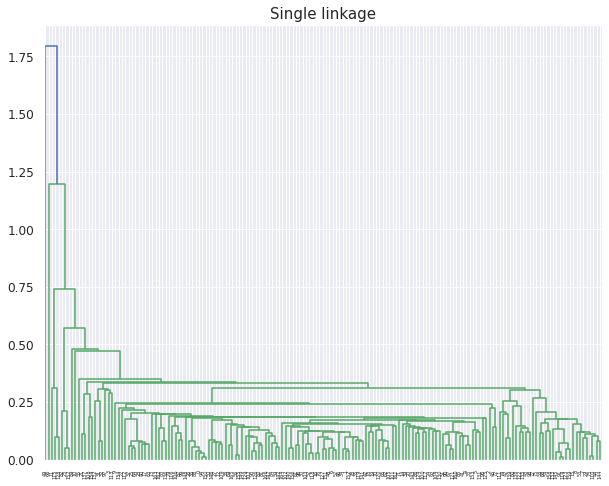

In [158]:
#single linkage
plt.figure(figsize=(10,8))
mergings = linkage(df1, method="single", metric='euclidean')
plt.title('Single linkage',fontsize = 15)
dendrogram(mergings)
plt.show()

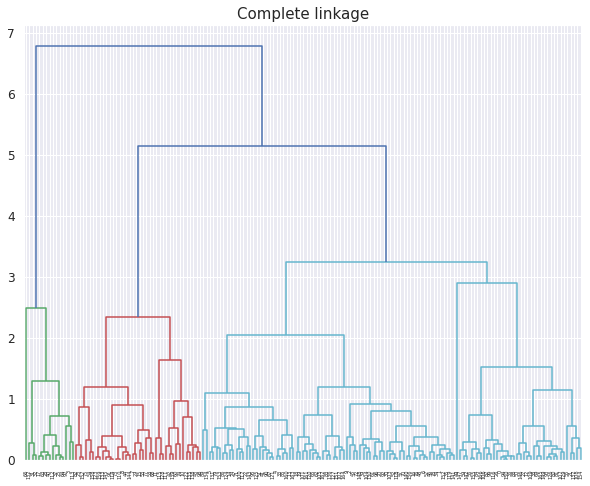

In [159]:
#complete linkage
plt.figure(figsize=(10,8))
mergings = linkage(df1, method="complete", metric='euclidean')
plt.title('Complete linkage',fontsize = 15)
dendrogram(mergings)
plt.show()


In [160]:

# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0])

In [161]:
# assign cluster labels
df['cluster_labels'] = cluster_labels
df.head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,1610.0,553,0,0
1,Albania,16.6,9930.0,4090,2,0
2,Algeria,27.3,12900.0,4460,2,0
3,Angola,119.0,5900.0,3530,0,1
4,Antigua and Barbuda,10.3,19100.0,12200,2,0


In [162]:
country_df['Hierarchical_Clusters'] = cluster_labels
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,k_means_cluster,Hierarchical_Clusters
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,2,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,2,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,2,0


In [163]:
country_df['Hierarchical_Clusters'].value_counts()

0    114
2     38
1     15
Name: Hierarchical_Clusters, dtype: int64

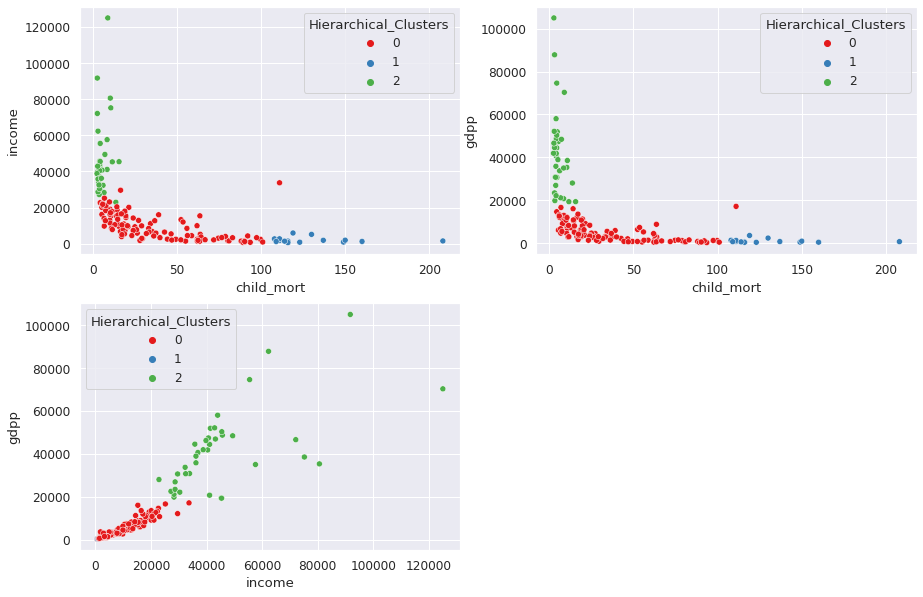

In [164]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'Hierarchical_Clusters', data = country_df, palette = 'Set1')
plt.subplot(2,2,2)
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'Hierarchical_Clusters', data = country_df, palette = 'Set1')
plt.subplot(2,2,3)
sns.scatterplot(x = 'income', y = 'gdpp', hue = 'Hierarchical_Clusters', data = country_df, palette = 'Set1')

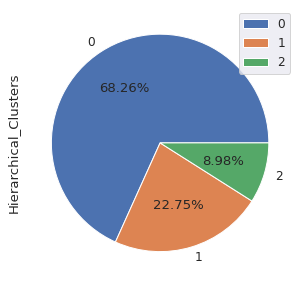

In [165]:
plt.figure(figsize= (5,5))
country_df['Hierarchical_Clusters'].value_counts().plot(kind= 'pie', legend = True, autopct='%1.2f%%',labels=[0,1,2], shadow=False)
plt.show()